In [2]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix

# Reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Paths 
TRAIN_DIR = "/kaggle/input/intel-image-classification/seg_train/seg_train"
TEST_DIR  = "/kaggle/input/intel-image-classification/seg_test/seg_test"

IMG_SIZE = (150, 150)   
BATCH_SIZE = 32
EPOCHS = 15

2025-09-26 16:51:35.580330: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1758905495.751689      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758905495.799946      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Bu hücrede temel kütüphaneleri yükleyip, proje için gerekli ayarları yapıyoruz.  

- **Reproducibility (Tekrar üretilebilirlik)**: Kodun her çalıştırıldığında aynı sonucu vermesi için rastgelelik ayarları yapıldı.  
- **Veri yolları**: Eğitim ve test veri klasörleri tanımlandı.  
- **Görsel boyutu**: Tüm görüntüler 150x150 piksele yeniden boyutlandırılacak.  
- **Batch ve Epoch**: Modelin eğitiminde kullanılacak batch boyutu 32, eğitim süresi 15 epoch olarak belirlendi.

Classes: ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
{'buildings': 2191, 'forest': 2271, 'glacier': 2404, 'mountain': 2512, 'sea': 2274, 'street': 2382}


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


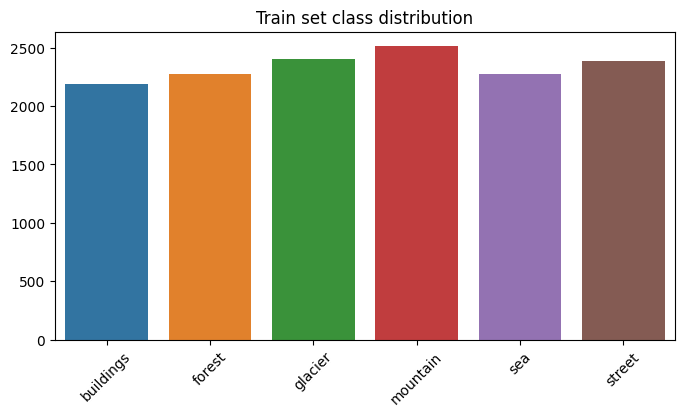

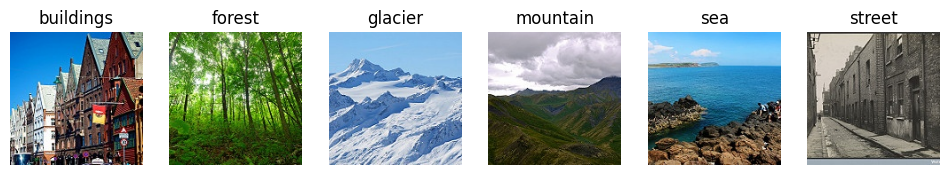

In [3]:
# Sınıf isimleri (train dizinindeki alt klasör isimleri)
classes = sorted(os.listdir(TRAIN_DIR))
print("Classes:", classes)

# Sınıf başına örnek sayısı
class_counts = {c: len(os.listdir(os.path.join(TRAIN_DIR, c))) for c in classes}
print(class_counts)

# Bar plot
plt.figure(figsize=(8,4))
sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()))
plt.xticks(rotation=45)
plt.title("Train set class distribution")
plt.show()

# Örnek görüntüler
def show_samples(folder, classes, ncol=6):
    plt.figure(figsize=(12,6))
    i=1
    for c in classes:
        p = os.path.join(folder, c)
        sample = random.choice(os.listdir(p))
        img = plt.imread(os.path.join(p, sample))
        plt.subplot(2, 6, i)
        plt.imshow(img)
        plt.title(c)
        plt.axis('off')
        i+=1
show_samples(TRAIN_DIR, classes)

# Veri Keşfi ve Görselleştirme

Bu hücrede eğitim verimize bakıyoruz:  

- **Sınıf isimleri**: Eğitim klasöründeki alt klasörler, veri setindeki kategorileri temsil ediyor.  
- **Sınıf başına örnek sayısı**: Her bir sınıfta kaç adet görsel bulunduğunu sayıyoruz ve bar grafiği ile görselleştiriyoruz.  
- **Örnek görüntüler**: Her sınıftan rastgele seçilen görselleri göstererek veri çeşitliliğini gözlemliyoruz.  

In [4]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.15,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True,
    seed=SEED
)

val_gen = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=True,
    seed=SEED
)

test_gen = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

num_classes = train_gen.num_classes
print("Num classes:", num_classes)

Found 11230 images belonging to 6 classes.
Found 2804 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.
Num classes: 6


# Veri Ön İşleme ve Data Generator

Bu hücrede modelin eğitimi için veri hazırlığını yapıyoruz:  

- **ImageDataGenerator ile veri artırımı (augmentation)**:  
  - Görselleri yeniden ölçeklendirme (0-1 aralığına)  
  - Rastgele döndürme, kaydırma, kesme, zoom ve yatay çevirme  
  - Eğitim sırasında modelin daha genel özellikler öğrenmesini sağlamak için  

- **Train / Validation / Test generator'ları**:  
  - Eğitim verisinin %80’i eğitim, %20’si doğrulama için kullanılıyor  
  - Test verisi sadece ölçekleniyor, shuffle yapılmıyor  

- **Sınıf sayısı**: Eğitim veri setindeki toplam sınıf sayısı `num_classes` değişkenine kaydedildi.  

In [5]:
def build_simple_cnn(input_shape=IMG_SIZE+(3,), num_classes=num_classes):
    model = models.Sequential([
        layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D(2,2),
        layers.Conv2D(64, (3,3), activation='relu'),
        layers.MaxPooling2D(2,2),
        layers.Conv2D(128, (3,3), activation='relu'),
        layers.MaxPooling2D(2,2),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

model = build_simple_cnn()
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1758905511.762457      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     4,735,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,829,126 (18.42 MB)

 Trainable params: 4,829,126 (18.42 MB)

 Non-trainable params: 0 (0.00 B)

# Basit CNN Modeli Oluşturma

Bu hücrede basit bir Convolutional Neural Network (CNN) modeli tanımlıyoruz:  

- **Katmanlar**:  
  - 3 adet Convolution + MaxPooling katmanı ile görsel özellikler çıkarılıyor  
  - Flatten katmanı ile 2D özellikler 1D vektöre dönüştürülüyor  
  - Dense katmanları ile sınıflandırma yapılıyor  
  - Dropout ile aşırı uyum (overfitting) önleniyor  

- **Çıkış katmanı**: `num_classes` sınıfa göre softmax aktivasyonu kullanılıyor  

- **Model derleme**:  
  - Optimizer: Adam  
  - Kayıp fonksiyonu: Categorical Crossentropy (çok sınıflı sınıflandırma için)  
  - Metrik: Accuracy  

In [6]:
# Keras callback importu
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard

# Eğitim sırasında en iyi modeli kaydeder (val_loss en düşük olduğunda)
checkpoint = ModelCheckpoint("best_model.h5", monitor='val_loss', save_best_only=True, verbose=1)

# Model iyileşmeyi durdurmadığında eğitim erken durur, overfitting önlenir
earlystop = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True, verbose=1)

# Val_loss durakladığında öğrenme oranını azaltır
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)

logdir = "/kaggle/working/logs"
tb = TensorBoard(log_dir=logdir)
cb = [checkpoint, earlystop, reduce_lr, tb]

# Model Eğitimi için Callback’ler

Bu hücrede model eğitimi sırasında kullanılacak callback’leri tanımlıyoruz:  

- **ModelCheckpoint**:  
  - Eğitim sırasında en iyi modeli (`val_loss` en düşük olduğunda) kaydeder.  

- **EarlyStopping**:  
  - Model doğrulama kaybında iyileşme durduğunda eğitimi erken durdurur, overfitting’i önler.  

- **ReduceLROnPlateau**:  
  - Doğrulama kaybı durakladığında öğrenme oranını azaltarak modeli iyileştirmeye yardımcı olur.  

- **TensorBoard**:  
  - Eğitim sürecini görselleştirmek ve izlemek için log dosyası oluşturur.  

- **Callback listesi (`cb`)**:  
  - Tüm callback’leri bir listeye ekleyip `model.fit()` sırasında kullanacağız.  

In [7]:
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS,
    callbacks=cb
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15


I0000 00:00:1758905516.558102     121 service.cc:148] XLA service 0x79eff80045a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1758905516.558929     121 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1758905516.897269     121 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1758905519.942553     121 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step - accuracy: 0.4404 - loss: 1.3733

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()



Epoch 1: val_loss improved from inf to 0.90890, saving model to best_model.h5
351/351 ━━━━━━━━━━━━━━━━━━━━ 122s 328ms/step - accuracy: 0.4407 - loss: 1.3728 - val_accuracy: 0.6626 - val_loss: 0.9089 - learning_rate: 0.0010
Epoch 2/15
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - accuracy: 0.6330 - loss: 0.9657
Epoch 2: val_loss improved from 0.90890 to 0.86140, saving model to best_model.h5
351/351 ━━━━━━━━━━━━━━━━━━━━ 77s 219ms/step - accuracy: 0.6330 - loss: 0.9656 - val_accuracy: 0.6783 - val_loss: 0.8614 - learning_rate: 0.0010
Epoch 3/15
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - accuracy: 0.6910 - loss: 0.8387
Epoch 3: val_loss improved from 0.86140 to 0.67095, saving model to best_model.h5
351/351 ━━━━━━━━━━━━━━━━━━━━ 77s 219ms/step - accuracy: 0.6910 - loss: 0.8386 - val_accuracy: 0.7618 - val_loss: 0.6710 - learning_rate: 0.0010
Epoch 4/15
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - accuracy: 0.7166 - loss: 0.7703
Epoch 4: val_loss improved from 0.67095 to 0.65771, saving m

# Model Eğitimi

Bu hücrede modeli tanımlanan eğitim ve doğrulama verileriyle eğitiyoruz:  

- **train_gen**: Eğitim verisi  
- **val_gen**: Doğrulama verisi  
- **epochs**: Belirlenen eğitim turu sayısı  
- **callbacks (cb)**: Eğitim sırasında en iyi modeli kaydetme, erken durdurma, öğrenme oranını ayarlama ve TensorBoard ile izleme  

- Eğitim sonucu `history` değişkeninde kaydedilir; eğitim ve doğrulama kaybı/başarımları burada saklanır.  

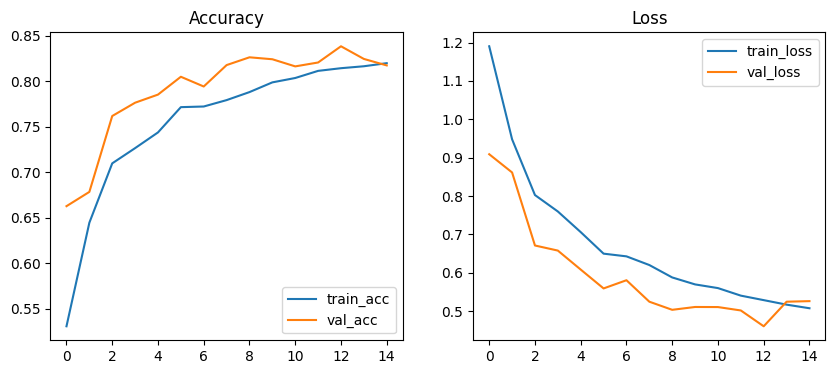

In [8]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.legend(); plt.title('Accuracy')

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend(); plt.title('Loss')
plt.show()

# Eğitim Sonuçlarının Görselleştirilmesi

Bu hücrede modelin eğitim sürecini grafiklerle inceliyoruz:  

- **Accuracy grafiği**:  
  - Eğitim (`train_acc`) ve doğrulama (`val_acc`) doğruluk değerlerini gösterir  
  - Modelin zaman içinde sınıflandırma başarımını gözlemlemeye yarar  

- **Loss grafiği**:  
  - Eğitim (`train_loss`) ve doğrulama (`val_loss`) kayıp değerlerini gösterir  
  - Modelin öğrenme sürecinde kaybın nasıl azaldığını takip etmemizi sağlar  

- Bu görseller sayesinde modelin overfitting veya underfitting yapıp yapmadığını kolayca görebiliriz.

94/94 ━━━━━━━━━━━━━━━━━━━━ 14s 142ms/step
              precision    recall  f1-score   support

   buildings       0.83      0.84      0.83       437
      forest       0.94      0.97      0.96       474
     glacier       0.87      0.75      0.80       553
    mountain       0.81      0.78      0.79       525
         sea       0.81      0.92      0.86       510
      street       0.86      0.87      0.87       501

    accuracy                           0.85      3000
   macro avg       0.85      0.85      0.85      3000
weighted avg       0.85      0.85      0.85      3000



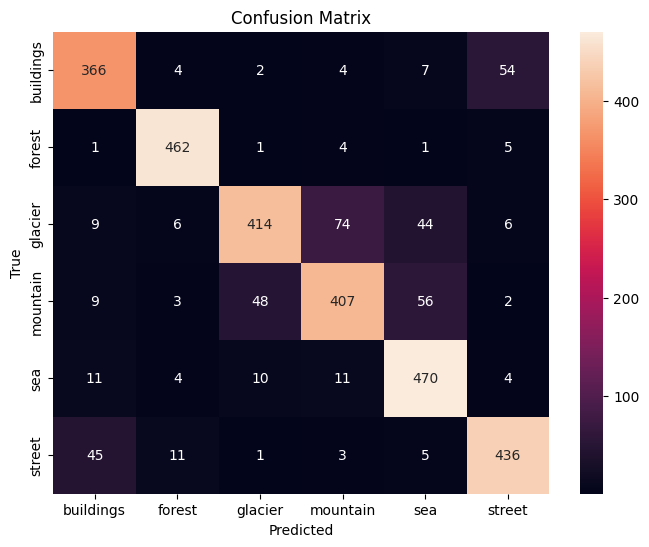

In [9]:
# Model en iyi ağırlıkları yüklü ise
model.load_weights("best_model.h5")

# Tahminler
y_pred_proba = model.predict(test_gen, verbose=1)
y_pred = np.argmax(y_pred_proba, axis=1)
y_true = test_gen.classes
labels = list(test_gen.class_indices.keys())

# Classification report
print(classification_report(y_true, y_pred, target_names=labels))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted'); plt.ylabel('True'); plt.title('Confusion Matrix')
plt.show()

# Model Değerlendirmesi

Bu hücrede test verisi üzerinde modelin performansını değerlendiriyoruz:  

- **En iyi ağırlıkları yükleme**:  
  - Eğitim sırasında `val_loss` en düşük olan modeli yüklüyoruz.  

- **Tahminler**:  
  - Test verisi üzerinde modelin olasılık tahminlerini (`y_pred_proba`) ve sınıf tahminlerini (`y_pred`) alıyoruz.  
  - Gerçek sınıflar `y_true` ile karşılaştırılıyor.  

- **Classification Report**:  
  - Her sınıf için precision, recall, f1-score ve support değerlerini gösterir.  

- **Confusion Matrix**:  
  - Gerçek ve tahmin edilen sınıfların karşılaştırmasını matris şeklinde görselleştirir.  
  - Hangi sınıflarda modelin daha iyi veya kötü performans gösterdiğini kolayca gözlemlemeye yarar.  


Training model with filters=32, learning_rate=0.001
Epoch 1/5
351/351 ━━━━━━━━━━━━━━━━━━━━ 83s 224ms/step - accuracy: 0.4757 - loss: 1.3676 - val_accuracy: 0.6451 - val_loss: 0.9384
Epoch 2/5
351/351 ━━━━━━━━━━━━━━━━━━━━ 75s 215ms/step - accuracy: 0.6475 - loss: 0.9217 - val_accuracy: 0.7422 - val_loss: 0.6916
Epoch 3/5
351/351 ━━━━━━━━━━━━━━━━━━━━ 76s 217ms/step - accuracy: 0.7163 - loss: 0.7820 - val_accuracy: 0.7368 - val_loss: 0.7002
Epoch 4/5
351/351 ━━━━━━━━━━━━━━━━━━━━ 76s 216ms/step - accuracy: 0.7447 - loss: 0.7119 - val_accuracy: 0.7700 - val_loss: 0.6127
Epoch 5/5
351/351 ━━━━━━━━━━━━━━━━━━━━ 76s 216ms/step - accuracy: 0.7657 - loss: 0.6529 - val_accuracy: 0.7810 - val_loss: 0.6009

Training model with filters=32, learning_rate=0.0005
Epoch 1/5
351/351 ━━━━━━━━━━━━━━━━━━━━ 80s 219ms/step - accuracy: 0.5005 - loss: 1.2799 - val_accuracy: 0.6772 - val_loss: 0.8728
Epoch 2/5
351/351 ━━━━━━━━━━━━━━━━━━━━ 76s 216ms/step - accuracy: 0.6789 - loss: 0.8574 - val_accuracy: 0.7315 - 

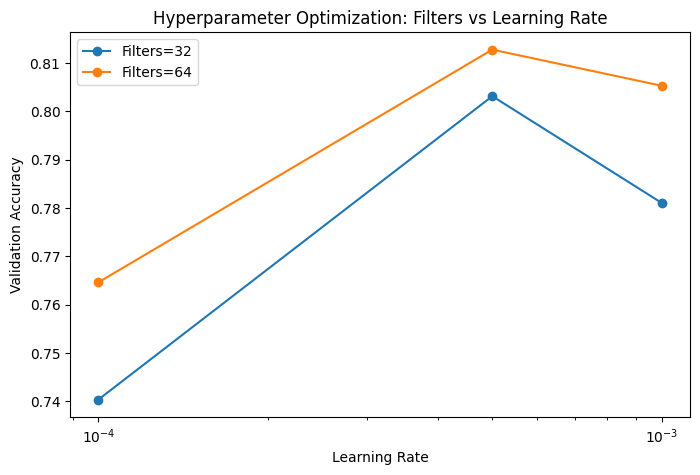

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers

# Denenecek hiperparametrelerin tanımı
learning_rates = [1e-3, 5e-4, 1e-4]
filter_options = [32, 64]

results = []

for filters in filter_options:
    for lr in learning_rates:
        print(f"\nTraining model with filters={filters}, learning_rate={lr}")

        model = keras.Sequential([
            keras.Input(shape=(150, 150, 3)),
            
            layers.Conv2D(filters, (3,3), activation='relu', padding="same"),
            layers.MaxPooling2D(2,2),

            layers.Conv2D(filters*2, (3,3), activation='relu', padding="same"),
            layers.MaxPooling2D(2,2),

            layers.Conv2D(filters*4, (3,3), activation='relu', padding="same"),
            layers.MaxPooling2D(2,2),

            layers.Flatten(),
            layers.Dense(256, activation='relu'),
            layers.Dropout(0.5),
            layers.Dense(train_gen.num_classes, activation='softmax')  # 6 sınıf
        ])

        model.compile(
            optimizer=keras.optimizers.Adam(learning_rate=lr),
            loss='categorical_crossentropy',  # bizde one-hot categorical label var
            metrics=['accuracy']
        )

        history = model.fit(
            train_gen,
            validation_data=val_gen,
            epochs=5,
            verbose=1
        )

        final_val_acc = history.history['val_accuracy'][-1]
        results.append({
            "filters": filters,
            "learning_rate": lr,
            "val_accuracy": final_val_acc
        })

# Sonuçların DataFrame haline getirilmesi
df = pd.DataFrame(results)
print("\nHyperparameter Results:")
print(df)

# Görselleştirme
plt.figure(figsize=(8,5))
for filters in filter_options:
    subset = df[df['filters']==filters]
    plt.plot(subset['learning_rate'], subset['val_accuracy'], marker='o', label=f'Filters={filters}')
plt.xscale('log')
plt.xlabel('Learning Rate')
plt.ylabel('Validation Accuracy')
plt.title('Hyperparameter Optimization: Filters vs Learning Rate')
plt.legend()
plt.show()

# Hiperparametre Deneyi

Bu hücrede modelin performansını artırmak için farklı hiperparametreleri test ediyoruz:  

- **Denenen hiperparametreler**:  
  - `learning_rates`: 0.001, 0.0005, 0.0001  
  - `filter_options`: 32 ve 64 filtre  

- **Model yapısı**:  
  - 3 adet Conv2D + MaxPooling katmanı  
  - Flatten + Dense katmanı ile sınıflandırma  
  - Dropout ile overfitting önleme  

- **Eğitim**:  
  - Her hiperparametre kombinasyonu için 5 epoch eğitim yapıldı  
  - Son doğrulama doğruluk (`val_accuracy`) kaydedildi  

- **Sonuçların değerlendirilmesi**:  
  - Hiperparametre kombinasyonlarının doğrulama doğrulukları bir DataFrame’de tutulur  
  - Grafik ile farklı learning rate ve filtre kombinasyonlarının performansı görselleştirilir  
  - Learning rate log ölçeğinde gösterilir, filtre sayısına göre çizgiler ayrılır  

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Tahmin sınıfı: buildings


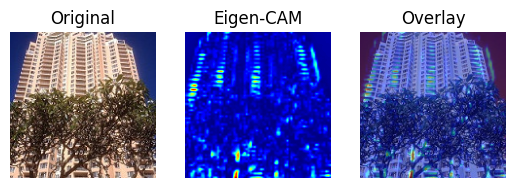

In [23]:
# tf-keras-vis kütüphanesi (Grad-CAM için gerekli)
!pip install tf-keras-vis

import matplotlib.pyplot as plt
import numpy as np, cv2, os
from tensorflow import keras
from tf_keras_vis.gradcam import GradcamPlusPlus
from tf_keras_vis.utils.scores import CategoricalScore


# Test görselini yükleme
# TEST_DIR içindeki 'buildings' klasöründen ilk resim seçimi
img_path = os.path.join(TEST_DIR, "buildings", os.listdir(os.path.join(TEST_DIR, "buildings"))[0])
orig = keras.utils.load_img(img_path, target_size=IMG_SIZE)
x = keras.utils.img_to_array(orig)
x = np.expand_dims(x, axis=0) / 255.0


# Tahmin yapımı
preds = model.predict(x)
pred_idx = np.argmax(preds[0])
print("Tahmin sınıfı:", classes[pred_idx])


# Grad-CAM++ ile görselleştirme
score = CategoricalScore([pred_idx])
cam = GradcamPlusPlus(model, clone=True)  # model_modifier çıkartıldı
heatmap = cam(score, x, penultimate_layer="conv2d_1")[0]


heatmap_resized = cv2.resize(heatmap, orig.size)
heatmap_resized = np.uint8(255 * heatmap_resized)
overlay = cv2.addWeighted(np.array(orig), 0.6,
                          cv2.applyColorMap(heatmap_resized, cv2.COLORMAP_JET), 0.4, 0)


plt.subplot(1,3,1); plt.title("Original"); plt.imshow(orig); plt.axis("off")
plt.subplot(1,3,2); plt.title("Eigen-CAM"); plt.imshow(heatmap, cmap="jet"); plt.axis("off")
plt.subplot(1,3,3); plt.title("Overlay"); plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB)); plt.axis("off")
plt.show()

# Grad-CAM++ ile Görselleştirme

Bu hücrede modelin karar verdiği bölgeleri görselleştiriyoruz:  

- **Test görseli seçimi**:  
  - `TEST_DIR` içindeki `buildings` klasöründen rastgele bir görsel seçildi  

- **Tahmin**:  
  - Modelin sınıf tahmini yapılıyor ve tahmin edilen sınıf yazdırılıyor  

- **Grad-CAM++**:  
  - Tahmin edilen sınıfın model üzerinde hangi bölgelere odaklandığını gösteren heatmap oluşturuluyor  
  - `penultimate_layer` olarak `conv2d_1` kullanıldı  

- **Görselleştirme**:  
  - Orijinal görsel  
  - Eigen-CAM heatmap  
  - Heatmap ve orijinal görselin overlay hali  

- Bu yöntem sayesinde modelin hangi görsel bölgelerine dikkat ettiğini ve kararını nasıl verdiğini anlayabiliyoruz.

In [30]:
print("Heatmap min:", heatmap.min())
print("Heatmap max:", heatmap.max())
print("Heatmap mean:", heatmap.mean())
print("Heatmap std:", heatmap.std())
max_pos = np.unravel_index(np.argmax(heatmap), heatmap.shape)
print("En yoğun nokta koordinatı:", max_pos)

Heatmap min: 0.0
Heatmap max: 0.99998426
Heatmap mean: 0.08335165
Heatmap std: 0.09446109
En yoğun nokta koordinatı: (149, 52)


# Grad-CAM++ Heatmap Analizi

Bu hücrede Grad-CAM++ heatmap'inin sayısal analizini yapıyoruz:  

- **Min ve Max değerler**: Heatmap'teki en düşük ve en yüksek dikkat değerlerini gösterir  
- **Ortalama ve Standart Sapma**: Heatmap genelindeki yoğunluğun istatistiksel özetini verir  
- **En yoğun nokta**: Modelin sınıf tahmini yaparken en çok dikkat ettiği pikselin koordinatları  

Bu sayede modelin karar sürecinde hangi bölgeleri daha çok dikkate aldığını sayısal olarak inceleyebiliriz.